In [37]:
import pandas as pd
import matplotlib.pyplot as plt
# from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import os
import dask.dataframe as ddf
import re
from scipy.stats import linregress

import sys
sys.path.append("..")

from channeling_lib import AWS_file_loader, load_path, filter_data_based_on_time

stations_str = ['Tom Joad','Rosanna','Bette Davis', 'Layla', 'Mrs Robinson']

# TinyTag_str = ['CEB_1', 'CEB_2', 'CEB_3', 'CEB_4', 'CEB_5', 'TH1', 'TH2', 'TH3', 'TH5', 'TH6', 'TH8', 'TT1', 'TT2', 'TT3', 'TT4', 'TT5', 'TT6', 'TT7', 'TT9', 'TT12', 'TT13', 'TT14', 'TT15', 'TT16', 'TT17', 'TT18']

In [11]:
path = load_path()+'RawData/TinyTag/'

instrument_textbook_name = load_path()+'instrument_textbook_BLcourse_spring2025(BL instruments).csv'
instrument_textbook_data = pd.read_csv(instrument_textbook_name, encoding='latin1')

# instrument_textbook_data['Station name']

# Formatting instrument textbook

This section of the code ensures consistency no matter what chnages in the excel file in sharepoint

In [12]:
# Extract station names (keep only prefix + number)
instrument_textbook_data['Formatted Name'] = [
    re.sub(r"(TT|TH|CEB)(\d+).*", r"\1\2", name) if re.match(r"(TT|TH|CEB)\d+", name) else name
    for name in instrument_textbook_data['Station name']
]

# Find duplicate names
duplicates = instrument_textbook_data['Formatted Name'].value_counts()
duplicate_names = duplicates[duplicates > 1].index  # Names that appear more than once

# Apply "_low" and "_high" based on "Th height (m)"
for name in duplicate_names:
    subset = instrument_textbook_data[instrument_textbook_data['Formatted Name'] == name]
    
    # Find the lowest and highest Th height
    min_index = subset['Th height (m)'].idxmin()
    max_index = subset['Th height (m)'].idxmax()
    
    # Rename them
    instrument_textbook_data.loc[min_index, 'Formatted Name'] = f"{name}_low"
    instrument_textbook_data.loc[max_index, 'Formatted Name'] = f"{name}_high"

# Get final formatted list
formatted_names = instrument_textbook_data['Formatted Name'].tolist()

# formatted_names

The following cell can ONLY be run once. If the following line soudl be 're-run', restart the kernal and run all

In [13]:
# Insert 'Formatted Name' as the first column
instrument_textbook_data.insert(0, 'Formatted Station Name', instrument_textbook_data.pop('Formatted Name'))

# Loading start and end times of Tinytag for calibration

In [14]:
# TinyTag_str = instrument_textbook_data['Station name'].tolist()
TinyTag_str = [s for s in formatted_names if s.startswith(("TT", "TH", "CEB"))]


# TinyTag_str

In [15]:
manual_times = {}

for station in TinyTag_str:
    setup_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Setup time (UTC)'].values[0])

    maintenance_start_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Maintenance start time (UTC)'].values[0])

    # maintenance_duration_idx = int(instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Maintenance duration (minutes)'].values[0])
    maintenance_duration_value = instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Maintenance duration (minutes)'].values[0]
    maintenance_duration_idx = int(maintenance_duration_value) if not pd.isna(maintenance_duration_value) else 0

    retrieval_time_idx = pd.to_datetime(instrument_textbook_data.loc[instrument_textbook_data['Formatted Station Name'] == station, 'Retrieval time (UTC)'].values[0])

    manual_times[station] = {
            'setup_time': setup_time_idx,
            'maintenance_start_time': maintenance_start_time_idx,
            'maintenance_duration': maintenance_duration_idx,
            'retrieval_time': retrieval_time_idx
        }

# manual_times

# Loading TinyTag  data

The TinyTag data is loaded using UNISasci function read_Tinytag(). The data is then loaded dynamically using load_TinyTag_folders() function (Alberte)

- Calibration data
    - ceb_calibration_data = load_TinyTag_folders(path, 'CEB', 'calibration')
    - TH_calibration_data = load_TinyTag_folders(path, 'TH', 'calibration')
    - TT_calibration_data = load_TinyTag_folders(path, 'TT', 'calibration')

- Actual data
    - ceb_data = load_TinyTag_folders(path, 'CEB', 'normal')
    - TH_data = load_TinyTag_folders(path, 'TH', 'normal')
    - TT_data = load_TinyTag_folders(path, 'TT', 'normal')


Specific data is selected by:
- tag_data['tag_i_normal_data']
- tag_calibration_data['tag_i_calibration_data']

Where i corresponds to the TinyTag number in teh raw data folder



In [16]:
#function from unis github
def read_Tinytag(filename, sensor):
    '''
    Reads data from one or several data files from the Tinytag output files.

    Parameters:
    -------
    filename: str
        String with path to file(s)
        If several files shall be read, specify a string including UNIX-style wildcards
    sensor: str
        One of "TT", "TH" or "CEB"
    Returns
    -------
    df : pandas dataframe
        a pandas dataframe with time as index and the individual variables as columns.
    '''

    import dask.dataframe as ddf


    if sensor == "TT":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T_black", "T_white"], encoding = "ISO-8859-1")
    elif sensor == "TH":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T", "RH"], encoding = "ISO-8859-1")
    elif sensor == "CEB":
        df = ddf.read_csv(filename, delimiter="\t", skiprows=5, parse_dates=[1], date_format="%d %b %Y %H:%M:%S", names=["RECORD", "TIMESTAMP", "T"], encoding = "ISO-8859-1")
    else:
        assert False, 'Sensortype of Tinytag not known. Should be one of "TT", "TH" or "CEB".'

    df = df.compute()
    df.set_index("TIMESTAMP", inplace=True)

    for key in list(df.columns):
        if key == "RECORD":
            pass
        else:
            data = [float(i.split(" ")[0]) for i in df[key]]
            unit = df[key].iloc[0].split(" ")[1]
            if unit == "°C":
                unit = "degC"
            new_key = f"{key}_{unit}"

            df[new_key] = data

            df.drop(key, axis=1, inplace=True)

    return df

In [8]:
# # Get all CEB_i folders inside TinyTag
# folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('CEB_')]

# # Dictionary to store the datasets
# calibration_data = {}

# # Loop through each CEB_i folder
# for folder in folders:
#     folder_path = os.path.join(path, folder)
    
#     # Get all .txt files that start with "CEB_i_calibration_"
#     files = [f for f in os.listdir(folder_path) if f.startswith(folder + "_calibration_") and f.endswith(".txt")]
    
#     for file in files:
#         file_path = os.path.join(folder_path, file)
        
#         # Run the read_Tinytag function
#         dataset = read_Tinytag(file_path, 'CEB')
        
#         # Store the dataset in a dictionary using the folder name as the key
#         calibration_data[f"{folder}_calibration_data"] = dataset

# # Loop over the stored datasets and assign them as individual variables
# for dataset_name in calibration_data.keys():
#     globals()[dataset_name] = calibration_data[dataset_name]

In [9]:
# # TH
# folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('TH')]

# # Dictionary to store the datasets
# calibration_data = {}

# for folder in folders:
#     folder_path = os.path.join(path, folder)
    
#     # Get all .txt files that start with "THi_calibration_"
#     files = [f for f in os.listdir(folder_path) if f.startswith(folder + "_calibration_") and f.endswith(".txt")]
    
#     for file in files:
#         file_path = os.path.join(folder_path, file)
        
#         # Run the read_Tinytag function
#         dataset = read_Tinytag(file_path, 'TH')
        
#         # Store the dataset in a dictionary using the folder name as the key
#         calibration_data[f"{folder}_calibration_data"] = dataset

# for dataset_name in calibration_data.keys():
#     globals()[dataset_name] = calibration_data[dataset_name]

In [10]:
# # TT
# folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith('TT')]

# # Dictionary to store the datasets
# calibration_data = {}

# for folder in folders:
#     folder_path = os.path.join(path, folder)
    
#     # Get all .txt files that start with "TTi_calibration_"
#     files = [f for f in os.listdir(folder_path) if f.startswith(folder + "_calibration_") and f.endswith(".txt")]
    
#     for file in files:
#         file_path = os.path.join(folder_path, file)
        
#         # Run the read_Tinytag function
#         dataset = read_Tinytag(file_path, 'TT')
        
#         # Store the dataset in a dictionary using the folder name as the key
#         calibration_data[f"{folder}_calibration_data"] = dataset

# for dataset_name in calibration_data.keys():
#     globals()[dataset_name] = calibration_data[dataset_name]

In [17]:
def load_TinyTag_folders(path, tag, datatype):
    """
    Processes folders that start with a specific prefix, reads corresponding files,
    and stores their datasets in a dictionary.
    """
    # prefix = 0
    # prefix = []
    if tag == 'CEB':
        prefix = 'CEB_'
    elif tag == 'TH':
        prefix = 'TH'
    elif tag == 'TT':
        prefix = 'TT'

    if datatype == 'calibration':
        folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith(prefix)]
        calibration_data = {}

        for folder in folders:
            folder_path = os.path.join(path, folder)
            files = [f for f in os.listdir(folder_path) if f.startswith(f"{folder}_calibration_") and f.endswith(".txt")]
            
            for file in files:
                file_path = os.path.join(folder_path, file)
                dataset = read_Tinytag(file_path, tag)  # Process the file
                calibration_data[f"{folder}_calibration_data"] = dataset
        
        return calibration_data
    
    elif datatype == 'normal':
        folders = [f for f in os.listdir(path) if os.path.isdir(os.path.join(path, f)) and f.startswith(prefix)]
        normal_data = {}

        for folder in folders:
            folder_path = os.path.join(path, folder)
            # Filter files that DO NOT contain "_calibration" in their name
            files = [f for f in os.listdir(folder_path) if "_calibration" not in f and f.endswith(".txt")]
            
            for file in files:
                file_path = os.path.join(folder_path, file)
                dataset = read_Tinytag(file_path, tag)  # Process the file
                normal_data[f"{folder}_normal_data"] = dataset  # Different key to distinguish

        return normal_data

        
# # Process all folder types
# all_data = {}
# for prefix, tag in zip(["CEB_", "TH", "TT"], ["CEB", "TH", "TT"]):
#     all_data.update(load_TinyTag_folders(path, prefix, tag))

# # Assign the datasets to global variables
# globals().update(all_data)


In [18]:
ceb_calibration_data = load_TinyTag_folders(path, 'CEB', 'calibration')
TH_calibration_data = load_TinyTag_folders(path, 'TH', 'calibration')
TT_calibration_data = load_TinyTag_folders(path, 'TT', 'calibration')

ceb_data = load_TinyTag_folders(path, 'CEB', 'normal')
TH_data = load_TinyTag_folders(path, 'TH', 'normal')
TT_data = load_TinyTag_folders(path, 'TT', 'normal')

Formatting the data to remove the seconds - yielding format yyyy-mm-dd h:m

In [19]:
datasets = [ceb_calibration_data, TH_calibration_data, TT_calibration_data,
            ceb_data, TH_data, TT_data]

# Loop through each dataset
for dataset in datasets:
    for key in dataset.keys():  # Iterate over each DataFrame inside the dictionary
        dataset[key].index = dataset[key].index.round('min')
        # dataset[key].index = pd.to_datetime(dataset[key].index.strftime('%Y-%m-%d %H:%M'))


In [20]:
ceb_calibration_data['CEB_1_calibration_data'].index

DatetimeIndex(['2025-01-24 09:31:00', '2025-01-24 09:32:00',
               '2025-01-24 09:33:00', '2025-01-24 09:34:00',
               '2025-01-24 09:35:00', '2025-01-24 09:36:00',
               '2025-01-24 09:37:00', '2025-01-24 09:38:00',
               '2025-01-24 09:39:00', '2025-01-24 09:40:00',
               ...
               '2025-01-25 15:32:00', '2025-01-25 15:33:00',
               '2025-01-25 15:34:00', '2025-01-25 15:35:00',
               '2025-01-25 15:36:00', '2025-01-25 15:37:00',
               '2025-01-25 15:38:00', '2025-01-25 15:39:00',
               '2025-01-25 15:40:00', '2025-01-25 15:41:00'],
              dtype='datetime64[ns]', name='TIMESTAMP', length=1811, freq=None)

# Filtering data based on setup and retrival times

Filter calibration data based on manual inspection of plotted data

In [21]:
calibration_filter_start_date = pd.Timestamp('2025-01-24 11:00:00')
calibration_filter_end_date = pd.Timestamp('2025-01-25 14:00:00')

Text(0.5, 0, 'Time')

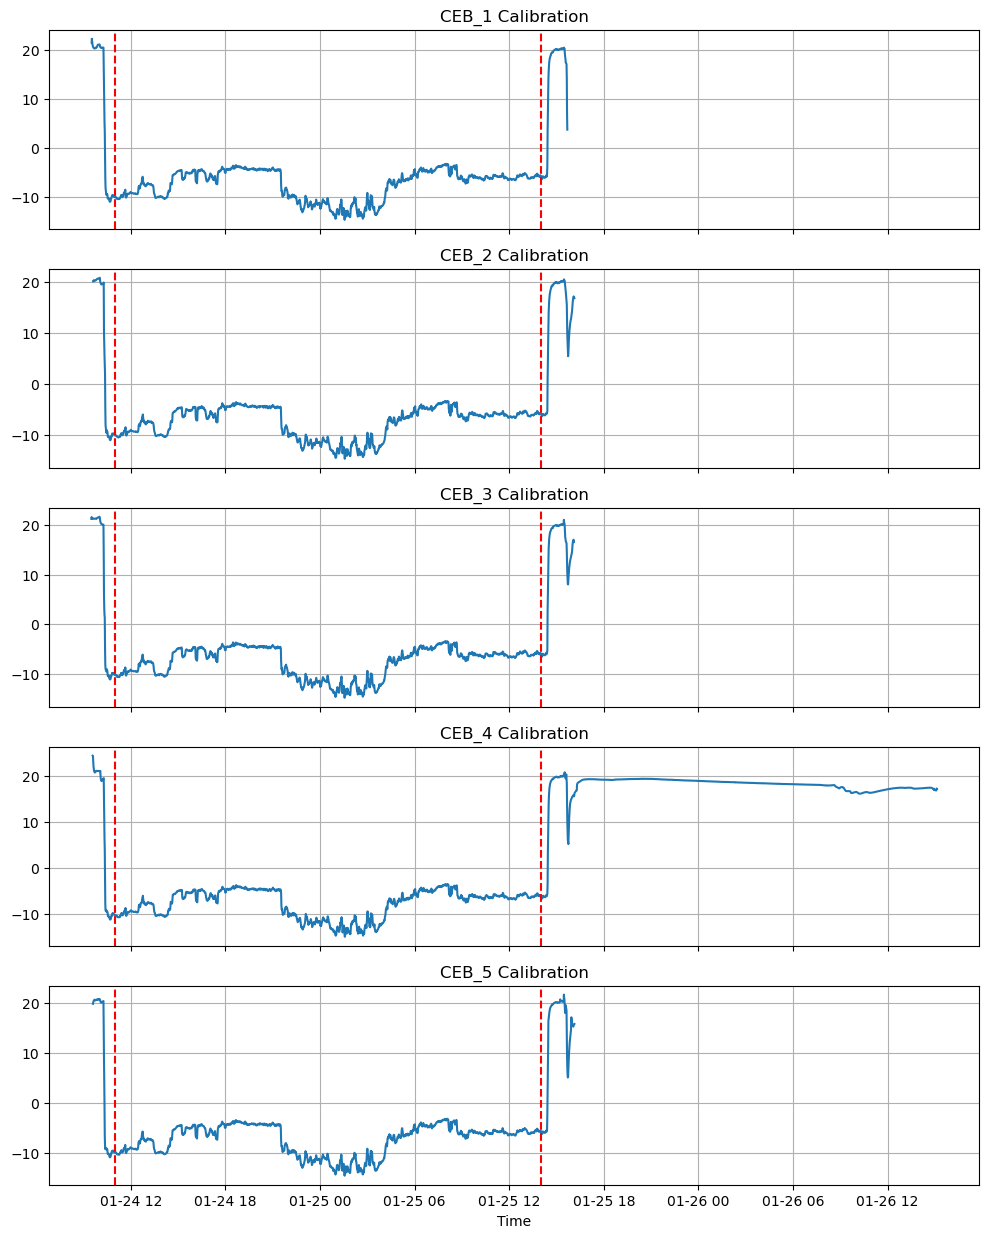

In [22]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(12, 15))  

# Example plotting each dataset in a different subplot
ax[0].plot(ceb_calibration_data['CEB_1_calibration_data'].index, 
           ceb_calibration_data['CEB_1_calibration_data'].T_degC, label='CEB_1')
ax[0].set_title("CEB_1 Calibration")

ax[1].plot(ceb_calibration_data['CEB_2_calibration_data'].index, 
           ceb_calibration_data['CEB_2_calibration_data'].T_degC, label='CEB_2')
ax[1].set_title("CEB_2 Calibration")

ax[2].plot(ceb_calibration_data['CEB_3_calibration_data'].index, 
           ceb_calibration_data['CEB_3_calibration_data'].T_degC, label='CEB_3')
ax[2].set_title("CEB_3 Calibration")

ax[3].plot(ceb_calibration_data['CEB_4_calibration_data'].index, 
           ceb_calibration_data['CEB_4_calibration_data'].T_degC, label='CEB_4')
ax[3].set_title("CEB_4 Calibration")

ax[4].plot(ceb_calibration_data['CEB_5_calibration_data'].index, 
           ceb_calibration_data['CEB_5_calibration_data'].T_degC, label='CEB_5')
ax[4].set_title("CEB_5 Calibration")

for a in ax:
    a.axvline(x = calibration_filter_start_date, color='red', linestyle='--')
    a.axvline(x = calibration_filter_end_date, color='red', linestyle='--')
    a.grid(True)

ax[-1].set_xlabel("Time")  # Set x-axis label on the last subplot

Remove data beofore and after red lines

In [23]:
# Loop through each DataFrame inside the dictionary and apply the filter
for key in ceb_calibration_data.keys():
    df = ceb_calibration_data[key]
    
    # Apply filter: Keep only rows within the start and end date range
    filtered_df = df[(df.index >= calibration_filter_start_date) & (df.index <= calibration_filter_end_date)]
    
    # Update the dataset with the filtered data
    ceb_calibration_data[key] = filtered_df


Text(0.5, 0, 'Time')

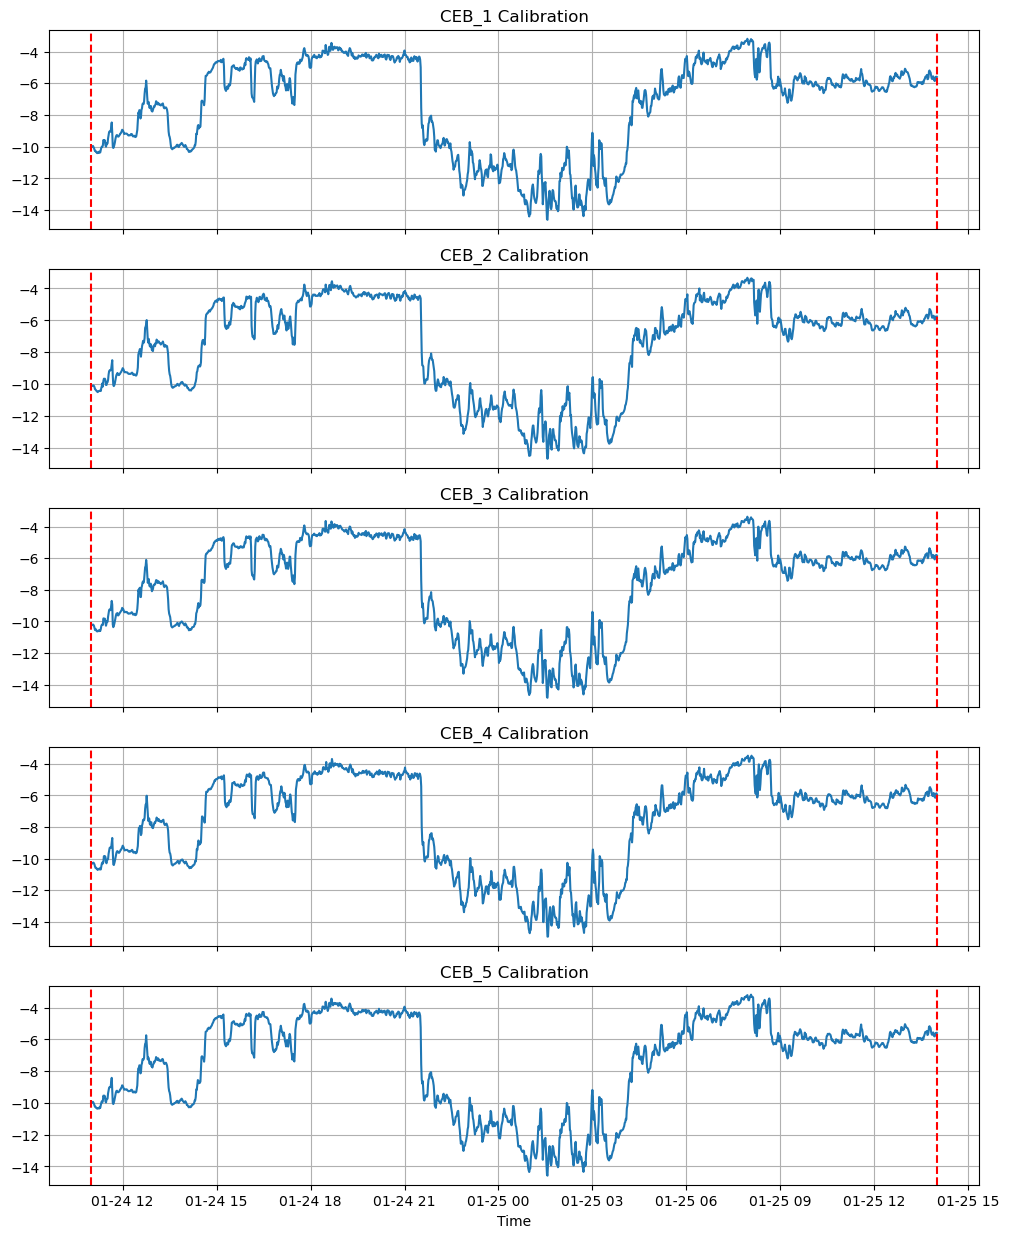

In [24]:
fig, ax = plt.subplots(nrows=5, sharex=True, figsize=(12, 15))  

# Example plotting each dataset in a different subplot
ax[0].plot(ceb_calibration_data['CEB_1_calibration_data'].index, 
           ceb_calibration_data['CEB_1_calibration_data'].T_degC, label='CEB_1')
ax[0].set_title("CEB_1 Calibration")

ax[1].plot(ceb_calibration_data['CEB_2_calibration_data'].index, 
           ceb_calibration_data['CEB_2_calibration_data'].T_degC, label='CEB_2')
ax[1].set_title("CEB_2 Calibration")

ax[2].plot(ceb_calibration_data['CEB_3_calibration_data'].index, 
           ceb_calibration_data['CEB_3_calibration_data'].T_degC, label='CEB_3')
ax[2].set_title("CEB_3 Calibration")

ax[3].plot(ceb_calibration_data['CEB_4_calibration_data'].index, 
           ceb_calibration_data['CEB_4_calibration_data'].T_degC, label='CEB_4')
ax[3].set_title("CEB_4 Calibration")

ax[4].plot(ceb_calibration_data['CEB_5_calibration_data'].index, 
           ceb_calibration_data['CEB_5_calibration_data'].T_degC, label='CEB_5')
ax[4].set_title("CEB_5 Calibration")

for a in ax:
    a.axvline(x = calibration_filter_start_date, color='red', linestyle='--')
    a.axvline(x = calibration_filter_end_date, color='red', linestyle='--')
    a.grid(True)

ax[-1].set_xlabel("Time")  # Set x-axis label on the last subplot

In [19]:
manual_times['TT12_low']

{'setup_time': Timestamp('2025-01-26 13:56:00'),
 'maintenance_start_time': NaT,
 'maintenance_duration': 0,
 'retrieval_time': Timestamp('2025-02-03 12:55:00')}

In [20]:
# TT_data

In [30]:
ceb_calibration_data['CEB_1_calibration_data']

,RECORD,T_degC
TIMESTAMP,,
2025-01-24 11:00:00,90,-10.02
2025-01-24 11:01:00,91,-10.02
2025-01-24 11:02:00,92,-10.00
2025-01-24 11:03:00,93,-9.95
2025-01-24 11:04:00,94,-10.01
...,...,...
2025-01-25 13:56:00,1706,-5.86
2025-01-25 13:57:00,1707,-5.67
2025-01-25 13:58:00,1708,-5.59


my additions:

                     T_degC_avg
TIMESTAMP                      
2025-01-24 11:00:00     -10.128
2025-01-24 11:01:00     -10.132
2025-01-24 11:02:00     -10.118
2025-01-24 11:03:00     -10.084
2025-01-24 11:04:00     -10.108


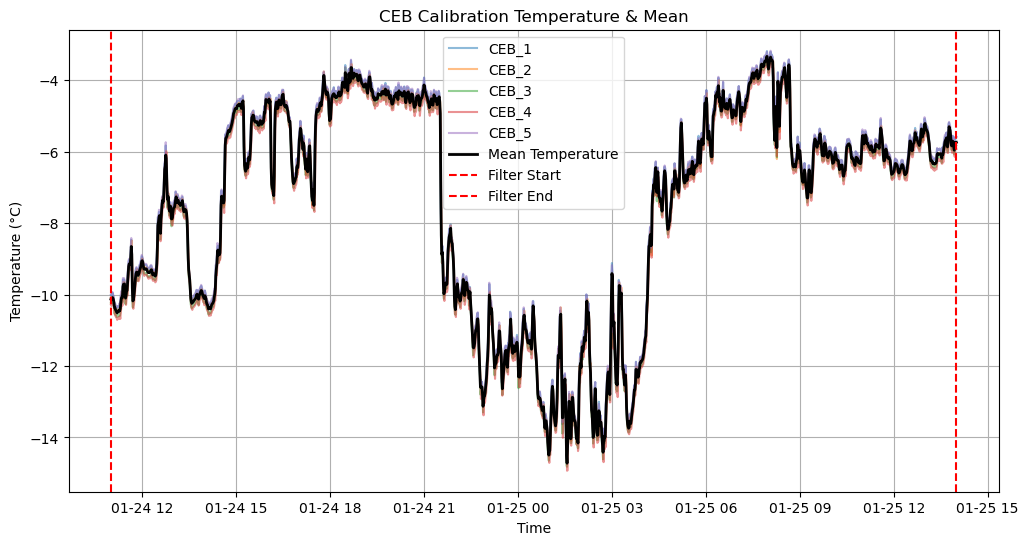

In [36]:

# Define start and end times for filtering
#calibration_filter_start_date = pd.Timestamp('2025-01-24 11:00:00')
#calibration_filter_end_date = pd.Timestamp('2025-01-25 14:00:00')

# Initialize the DataFrame with the first dataset
df_avg = ceb_calibration_data['CEB_1_calibration_data'][['T_degC']].rename(columns={'T_degC': 'CEB_1'})

# Merge with the other CEB datasets using Timestamp as the index
df_avg = df_avg.merge(ceb_calibration_data['CEB_2_calibration_data'][['T_degC']].rename(columns={'T_degC': 'CEB_2'}),
                      left_index=True, right_index=True, how='outer')

df_avg = df_avg.merge(ceb_calibration_data['CEB_3_calibration_data'][['T_degC']].rename(columns={'T_degC': 'CEB_3'}),
                      left_index=True, right_index=True, how='outer')

df_avg = df_avg.merge(ceb_calibration_data['CEB_4_calibration_data'][['T_degC']].rename(columns={'T_degC': 'CEB_4'}),
                      left_index=True, right_index=True, how='outer')

df_avg = df_avg.merge(ceb_calibration_data['CEB_5_calibration_data'][['T_degC']].rename(columns={'T_degC': 'CEB_5'}),
                      left_index=True, right_index=True, how='outer')

# **Calculate mean temperature per timestamp**
df_avg['T_degC_avg'] = df_avg[['CEB_1', 'CEB_2', 'CEB_3', 'CEB_4', 'CEB_5']].mean(axis=1, skipna=True)

# **Filter the dataset within the defined time range**
#df_avg = df_avg[(df_avg.index >= calibration_filter_start_date) & (df_avg.index <= calibration_filter_end_date)]

# **Keep only the Timestamp index and the mean temperature column**
df_avg = df_avg[['T_degC_avg']]

# **Preview the calculated means**
print(df_avg.head())

# **Plot the CEB temperature data and the mean**
plt.figure(figsize=(12, 6))

# Plot individual CEB temperature data with transparency
plt.plot(df_avg.index, ceb_calibration_data['CEB_1_calibration_data']['T_degC'], label='CEB_1', alpha=0.5)
plt.plot(df_avg.index, ceb_calibration_data['CEB_2_calibration_data']['T_degC'], label='CEB_2', alpha=0.5)
plt.plot(df_avg.index, ceb_calibration_data['CEB_3_calibration_data']['T_degC'], label='CEB_3', alpha=0.5)
plt.plot(df_avg.index, ceb_calibration_data['CEB_4_calibration_data']['T_degC'], label='CEB_4', alpha=0.5)
plt.plot(df_avg.index, ceb_calibration_data['CEB_5_calibration_data']['T_degC'], label='CEB_5', alpha=0.5)

# **Plot the mean temperature with a bold line**
plt.plot(df_avg.index, df_avg['T_degC_avg'], label='Mean Temperature', color='black', linewidth=2)

# **Add vertical lines for the filtering window**
plt.axvline(x=calibration_filter_start_date, color='red', linestyle='--', label="Filter Start")
plt.axvline(x=calibration_filter_end_date, color='red', linestyle='--', label="Filter End")

# **Format the plot**
plt.xlabel("Time")
plt.ylabel("Temperature (°C)")
plt.title("CEB Calibration Temperature & Mean")
plt.legend(loc="best")
plt.grid(True)

# **Show the plot**
plt.show()


In [33]:
print(df_avg.columns)


Index(['T_degC_avg'], dtype='object')


In [42]:
# Extract the correct station names from the dictionary
actual_station_names = list(ceb_calibration_data.keys())  
print(f"✅ Found station names: {actual_station_names}")

# Remove the "_calibration_data" suffix to match expected names
station_map = {name: name.replace("_calibration_data", "") for name in actual_station_names}

# Rename columns in `all_ceb_data` accordingly
all_ceb_data.rename(columns=station_map, inplace=True)

# Verify new column names
print("✅ Updated column names in all_ceb_data:", all_ceb_data.columns.tolist())



✅ Found station names: ['CEB_1_calibration_data', 'CEB_2_calibration_data', 'CEB_3_calibration_data', 'CEB_4_calibration_data', 'CEB_5_calibration_data']
✅ Updated column names in all_ceb_data: ['CEB_1', 'CEB_2', 'CEB_3', 'CEB_4', 'CEB_5', 'T_degC_avg']


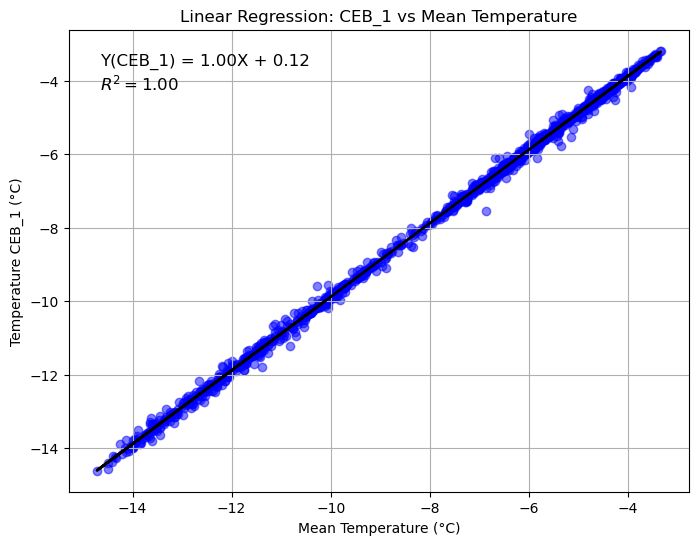

CEB_1: y = 1.000x + 0.118, R² = 0.999, p-value = 0.00000, std_err = 0.001


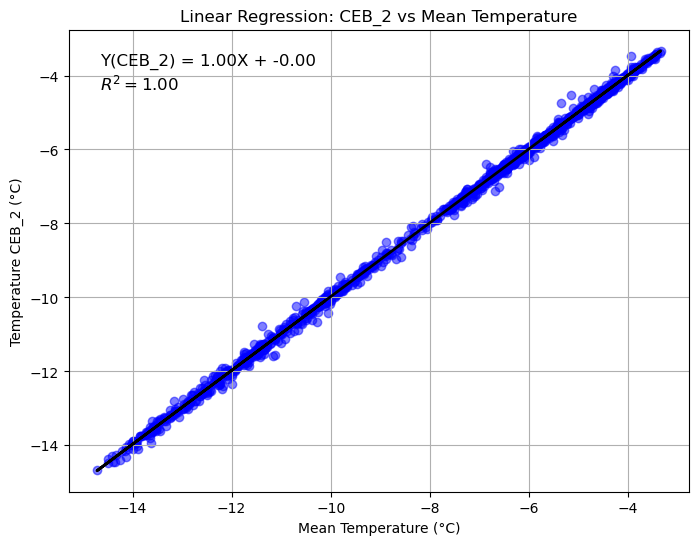

CEB_2: y = 0.997x + -0.004, R² = 0.999, p-value = 0.00000, std_err = 0.001


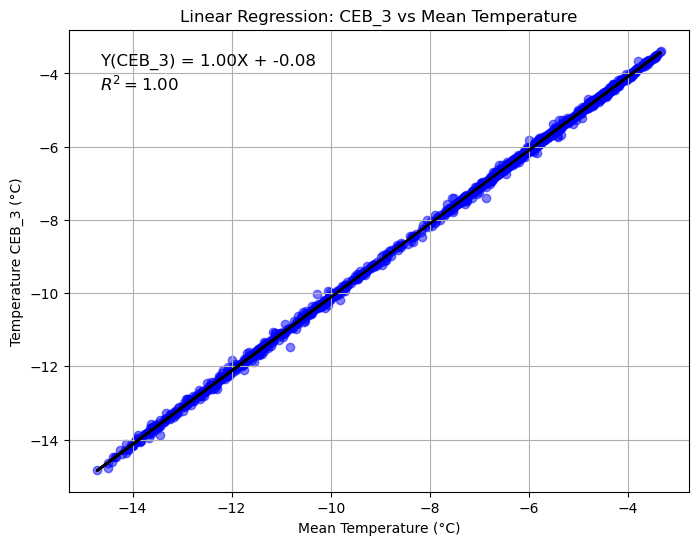

CEB_3: y = 1.004x + -0.077, R² = 1.000, p-value = 0.00000, std_err = 0.000


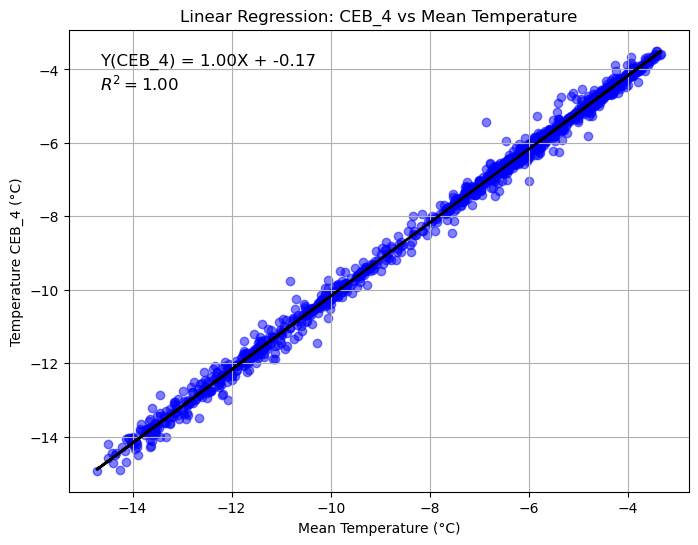

CEB_4: y = 1.000x + -0.168, R² = 0.997, p-value = 0.00000, std_err = 0.001


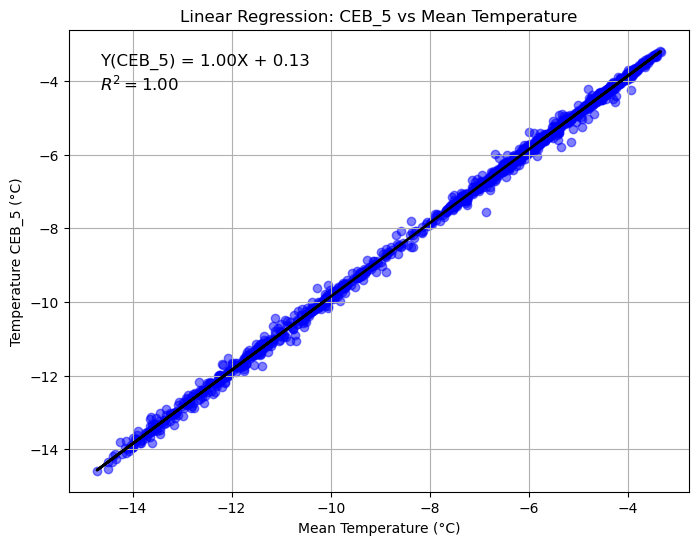

CEB_5: y = 0.998x + 0.131, R² = 0.999, p-value = 0.00000, std_err = 0.001


In [43]:

# **Loop through actual station names**
for station in station_map.values():  # Now using correct names
    if station not in all_ceb_data.columns:
        print(f"⚠️ Warning: {station} not found in data, skipping.")
        continue

    # **Merge station data with mean temperature using INNER JOIN**
    df_scatter = all_ceb_data[[station]].merge(all_ceb_data[['T_degC_avg']], 
                                               left_index=True, right_index=True, how='inner')

    # **Perform linear regression**
    slope, intercept, r_value, p_value, std_err = linregress(df_scatter['T_degC_avg'], df_scatter[station])
    regression_line = slope * df_scatter['T_degC_avg'] + intercept

    # **Plot scatter and regression line**
    plt.figure(figsize=(8, 6))
    plt.scatter(df_scatter['T_degC_avg'], df_scatter[station], color='blue', alpha=0.5)
    plt.plot(df_scatter['T_degC_avg'], regression_line, color='black', linewidth=2)

    # **Add regression equation and R² value**
    equation_text = f'Y({station}) = {slope:.2f}X + {intercept:.2f}\n$R^2 = {r_value**2:.2f}$'
    plt.text(0.05, 0.95, equation_text, transform=plt.gca().transAxes, 
             fontsize=12, verticalalignment='top', horizontalalignment='left', color='black')

    # **Plot labels and formatting**
    plt.xlabel('Mean Temperature (°C)')
    plt.ylabel(f'Temperature {station} (°C)')
    plt.title(f'Linear Regression: {station} vs Mean Temperature')
    plt.grid(True)

    # **Show the plot**
    plt.show()

    # **Print regression results**
    print(f"{station}: y = {slope:.3f}x + {intercept:.3f}, R² = {r_value**2:.3f}, p-value = {p_value:.5f}, std_err = {std_err:.3f}")


In [41]:
print("Available columns in all_ceb_data:")
print(all_ceb_data.columns.tolist())


Available columns in all_ceb_data:
['CEB_1_calibration_data', 'CEB_2_calibration_data', 'CEB_3_calibration_data', 'CEB_4_calibration_data', 'CEB_5_calibration_data', 'T_degC_avg']
